In [364]:
import numpy

from objects import NormalModel, TransitionDensity
from utils import rand_obs, rand_nnd, model_extract, transmutator
import matplotlib.pyplot as plt
from numpy import ndarray as Array
from funcs import forward, backward, beyond
from memory import DLModelMemory, DLModelPrimeMemory

In [365]:
# Dimensional parameters
n: "int" = 1
m: "int" = 1
p: "int" = 2

# Model's observable period
period: "int" = 100

# Model's predicted period
beyond_period: "int" = 10

# Primordial model setting
n0: "NormalModel" = rand_obs((p,n))
n0.covariance = rand_nnd(p, 1)

# Evolver setting
b_e: "Array" = numpy.zeros((p, n)) # p by n
a_e: "Array" = numpy.array([[1,1],[0,1]]) # p by p
v_e: "Array" = numpy.eye(p) * 1
te: "TransitionDensity" = TransitionDensity(b_e, a_e, v_e)

# Predictor setting
b_p: "Array" = numpy.zeros((m, n)) # m by n
a_p: "Array" = numpy.array([[1,0]]) # m by p
v_p: "Array" = numpy.eye(m) * 50
tp: "TransitionDensity" = TransitionDensity(b_p, a_p, v_p)

In [366]:
prime: "DLModelPrimeMemory" = DLModelPrimeMemory(n=n, m=m, p=p, period=period, beyond_period=beyond_period, n0=n0, te=te, tp=tp)
memory: "DLModelMemory" = DLModelMemory()

In [367]:
memory = forward(
    prime=prime,
    memory=memory
)
memory = backward(
    prime=prime,
    memory=memory
)
memory = beyond(
    prime=prime,
    memory=memory
)

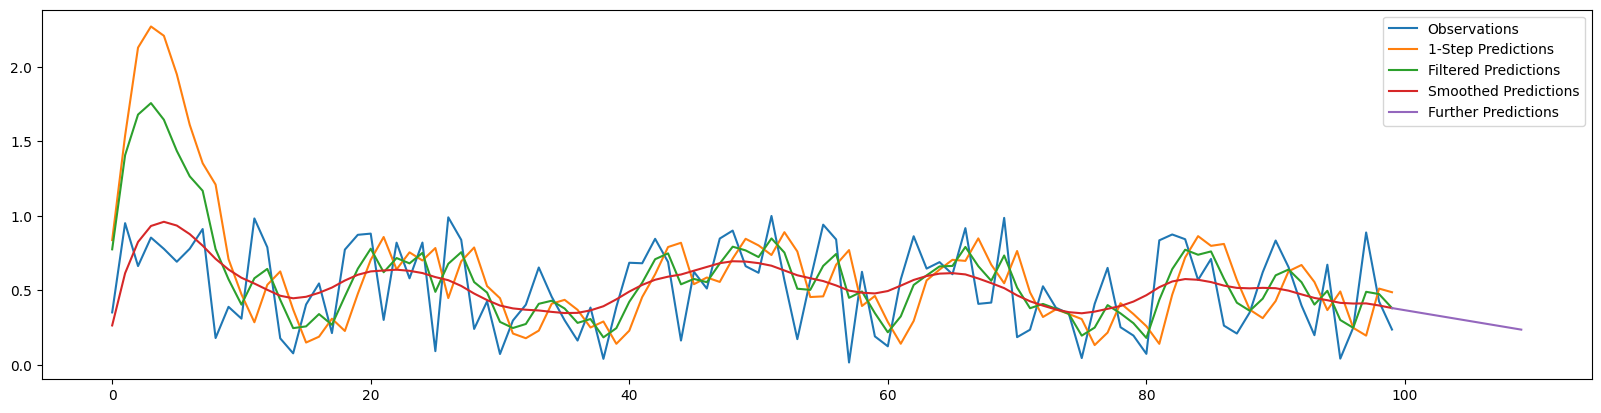

In [369]:
fig, ax = plt.subplots()
x1_data = list(range(period))
x2_data = list(range(period-1, period + beyond_period))
y1_data = list(model_extract(memory.o2))
y2_data = list(model_extract(memory.e2))
y3_data = list(model_extract(memory.f2))
y4_data = list(model_extract(memory.s2))
y5_data = list(model_extract(memory.p2))
ax.plot(x1_data, y1_data, label="Observations")
ax.plot(x1_data, y2_data, label="1-Step Predictions")
ax.plot(x1_data, y3_data, label="Filtered Predictions")
ax.plot(x1_data, y4_data, label="Smoothed Predictions")
ax.plot(x2_data, y5_data, label="Further Predictions")
ax.legend()
fig.set_figwidth(20)
plt.show()